In [ ]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-12-13 09:26:43--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  7.61MB/s    in 1.7s    

2024-12-13 09:26:45 (7.61 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# 데이터 불러오기
df = pd.read_csv('./jena_climate_2009_2016.csv')


# 기온 데이터 추출
temperatures = df[['T (degC)']].to_numpy().astype(np.float32)
temperatures = temperatures[:50000]


# 학습/검증/테스트 분할
num_data = len(temperatures)
train_size = int(num_data * 0.8)
val_size = int(num_data * 0.1)

train_data = temperatures[:train_size]
val_data = temperatures[train_size:train_size + val_size]
test_data = temperatures[train_size + val_size:]


# 표준화
scaler = StandardScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
# 데이터셋
class JenaTemperatureDataset(Dataset):
    def __init__(self, temperatures, sequence_length):
        self.temperatures = temperatures
        self.sequence_length = sequence_length

    def __getitem__(self, index):
        inputs = self.temperatures[index:index+self.sequence_length]
        targets = self.temperatures[index+1:index+self.sequence_length+1]

        return torch.tensor(inputs), torch.tensor(targets)

    def __len__(self):
        return len(self.temperatures) - self.sequence_length

sequence_length = 24
train_dataset = JenaTemperatureDataset(train_data_scaled, sequence_length)
val_dataset = JenaTemperatureDataset(val_data_scaled, sequence_length)
test_dataset = JenaTemperatureDataset(test_data_scaled, sequence_length)

# 데이터로더
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

In [ ]:
# 모델
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        output = self.linear(lstm_output)

        return output


model = LSTMModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
epochs = 5
step = 0
for epoch in range(epochs):
    model.train()
    for train_batch in train_dataloader:
        inputs = train_batch[0].to(device)
        targets = train_batch[1].to(device)
        preds = model(inputs)
        loss = loss_fn(preds, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        step += 1
        if step % 100 == 0:
            print(f'step {step}, train loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        losses = []
        for val_batch in val_dataloader:
            inputs = val_batch[0].to(device)
            targets = val_batch[1].to(device)
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            losses.append(loss.item())

    val_loss_avg = sum(losses) / len(losses)
    print(f'\nepoch {epoch+1}/{epochs}, val loss: {val_loss_avg:.4f}\n')

step 100, train loss: 0.0782
step 200, train loss: 0.0367
step 300, train loss: 0.0257

epoch 1/5, val loss: 0.0100

step 400, train loss: 0.0109
step 500, train loss: 0.0067
step 600, train loss: 0.0028

epoch 2/5, val loss: 0.0012

step 700, train loss: 0.0017
step 800, train loss: 0.0014
step 900, train loss: 0.0017

epoch 3/5, val loss: 0.0007

step 1000, train loss: 0.0012
step 1100, train loss: 0.0015
step 1200, train loss: 0.0014

epoch 4/5, val loss: 0.0006

step 1300, train loss: 0.0013
step 1400, train loss: 0.0009
step 1500, train loss: 0.0009

epoch 5/5, val loss: 0.0005



In [ ]:
test_preds = []
model.eval()
with torch.no_grad():
    for test_batch in test_dataloader:
        inputs = test_batch[0].to(device)
        preds = model(inputs) # [batch size, sequence length, 1]
        test_preds.append(preds[:, -1, :])

    test_preds = torch.cat(test_preds, dim=0)
    test_preds = test_preds.cpu().numpy()
    test_preds = scaler.inverse_transform(test_preds)

In [ ]:
test_targets = test_data[sequence_length:]

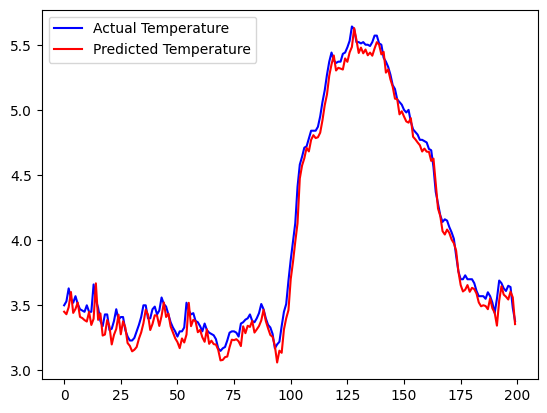

In [ ]:
import matplotlib.pyplot as plt

plt.plot(test_targets[:200], color='blue', label='Actual Temperature')
plt.plot(test_preds[:200], color='red', label='Predicted Temperature')
plt.legend()
plt.show()